In [93]:
# Cell 1: Ensure required packages and set style
import sys, subprocess, os, warnings

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

try:
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
except ImportError:
    for pkg in ["pandas", "numpy", "seaborn", "matplotlib"]:
        pip_install(pkg)
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

try:
    from geopy.distance import geodesic
except ImportError:
    pip_install("geopy")
    from geopy.distance import geodesic

try:
    import sklearn
except ImportError:
    pip_install("scikit-learn")
    import sklearn

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")
DATADIR = "../data"
IMAGESCSV = os.path.join(DATADIR, "images.csv")
GPSCSV = os.path.join(DATADIR, "BfRw Petrogale lateralis.csv")
FIGDIR = "./figures"
os.makedirs(FIGDIR, exist_ok=True)
print(f"Environment ready. Figures will be saved to: {os.path.abspath(FIGDIR)}")


Environment ready. Figures will be saved to: /Users/harishbogam/Documents/Extinction_Prediction_Project/notebooks/figures


In [94]:
# Cell 2: Load CSVs with robust fallback
print("Loading images.csv ...")
try:
    imagesdf = pd.read_csv(IMAGESCSV, low_memory=False)
    print(f"images.csv loaded successfully, rows: {len(imagesdf)}")
except FileNotFoundError:
    print("Error: images.csv not found. Please check the file path.")
    imagesdf = pd.DataFrame()

print("Loading BfRw Petrogale lateralis.csv ...")
try:
    gpsdf = pd.read_csv(GPSCSV, low_memory=False)
    print(f"BfRw Petrogale lateralis.csv loaded, rows: {len(gpsdf)}")
except FileNotFoundError:
    print("Error: BfRw Petrogale lateralis.csv not found. Please check the file path.")
    gpsdf = pd.DataFrame()

print("--- Head of imagesdf ---\n", imagesdf.head())
print("--- Info on imagesdf ---")
imagesdf.info()
print("--- Head of gpsdf ---\n", gpsdf.head())
print("--- Info on gpsdf ---")
gpsdf.info()


Loading images.csv ...
images.csv loaded successfully, rows: 45302
Loading BfRw Petrogale lateralis.csv ...
BfRw Petrogale lateralis.csv loaded, rows: 15470
--- Head of imagesdf ---
    project_id                  deployment_id  \
0     2006646  Camí del corretger 03/04/2024   
1     2006646           La Urraca 04/30/2024   
2     2006646           La Urraca 04/30/2024   
3     2006646           La Urraca 04/30/2024   
4     2006646           La Urraca 04/30/2024   

                               image_id  sequence_id      filename  \
0  85dff751-3948-419d-a26b-9bf785f942c5          NaN  IMG_0016.JPG   
1  ecaa42e1-d78b-4b7f-a4de-030d15099ed4          NaN  IMG_0134.JPG   
2  5399292c-c039-48bb-85a6-eff866f00f61          NaN  IMG_0643.JPG   
3  36369c6b-6b36-491c-aa46-f3c126d824bc          NaN  IMG_1155.JPG   
4  b72bc946-a207-40ee-9c2d-56314adbb0c0          NaN  IMG_1436.JPG   

                                            location  is_blank  \
0  https://app.wildlifeinsights.org/downl

In [95]:
# Cell 3: Clean images dataframe
required_img = ['deployment_id', 'common_name', 'timestamp', 'is_blank']
missing_img = set(required_img) - set(imagesdf.columns)
if missing_img:
    raise ValueError(f"images.csv missing columns: {missing_img}")

generic_labels = ['Blank', 'Animal', 'Bird', 'Human-Camera Trapper', 'Turdidae Family']

imagesdf['timestamp'] = pd.to_datetime(imagesdf['timestamp'], errors='coerce')

if imagesdf['is_blank'].dtype == object:
    imagesdf['is_blank'] = imagesdf['is_blank'].astype(str).str.lower().map({'true': True, 'false': False})

imagesdf_cleaned = (
    imagesdf
    .dropna(subset=['deployment_id', 'common_name', 'timestamp'])
    .query('is_blank != True')
    .query('common_name not in @generic_labels')
    .drop_duplicates(subset=['deployment_id', 'timestamp', 'filename', 'common_name'], keep='first')
    .copy()
)

imagesdf_cleaned['date'] = imagesdf_cleaned['timestamp'].dt.floor('D')

sighting_counts = (
    imagesdf_cleaned
    .groupby(['common_name', 'date'])
    .size()
    .reset_index(name='dailysightingcount')
)

topspecies = imagesdf_cleaned['common_name'].value_counts().head(10).index.tolist()
topspeciesdf = imagesdf_cleaned[imagesdf_cleaned['common_name'].isin(topspecies)]

print(f"Cleaned images rows: {len(imagesdf_cleaned)}")
print(f"Unique deployments: {imagesdf_cleaned['deployment_id'].nunique()}")
print("Top-10 species:", topspecies)


Cleaned images rows: 22218
Unique deployments: 73
Top-10 species: ['European Roe Deer', 'Wild Boar', 'Domestic Cattle', 'European Rabbit', 'House Rat', 'Red Fox', 'Eurasian Badger', 'Iberian Wild Goat', 'Red Deer', 'Human-Pedestrian']


Feature Engineering

In [96]:
# Cell 4: Build GPS features: speed, distance; fix negatives/outliers
gpsdf["timestamp"] = pd.to_datetime(gpsdf["timestamp"], errors="coerce")
gpsdf = gpsdf.sort_values(["individual-local-identifier", "timestamp"]).copy()

gpsdf["latprev"] = gpsdf.groupby("individual-local-identifier")["location-lat"].shift(1)
gpsdf["lonprev"] = gpsdf.groupby("individual-local-identifier")["location-long"].shift(1)
gpsdf["timeprev"] = gpsdf.groupby("individual-local-identifier")["timestamp"].shift(1)

def geokm(row):
    if pd.isna(row["latprev"]) or pd.isna(row["lonprev"]):
        return np.nan
    return geodesic((row["location-lat"], row["location-long"]), (row["latprev"], row["lonprev"])).km

gpsdf["distancetraveledkm"] = gpsdf.apply(geokm, axis=1)
gpsdf["timediffminutes"] = (gpsdf["timestamp"] - gpsdf["timeprev"]).dt.total_seconds() / 60
gpsdf.loc[gpsdf["timediffminutes"] <= 0, "timediffminutes"] = np.nan
gpsdf["speedkmh"] = gpsdf["distancetraveledkm"] / gpsdf["timediffminutes"] * 60
cap = gpsdf["speedkmh"].quantile(0.99)
gpsdf.loc[gpsdf["speedkmh"] > cap, "speedkmh"] = cap

print("--- GPS Engineered Features ---\n", gpsdf[["individual-local-identifier", "timestamp", "location-lat", "location-long", "distancetraveledkm", "timediffminutes", "speedkmh"]].head(10))


--- GPS Engineered Features ---
   individual-local-identifier           timestamp  location-lat  \
0                        NP12 2019-08-17 00:01:00    -31.667917   
1                        NP12 2019-08-17 03:00:32    -31.668119   
2                        NP12 2019-08-17 03:20:36    -31.667989   
3                        NP12 2019-08-17 05:01:00    -31.667886   
4                        NP12 2019-08-17 05:20:34    -31.667878   
5                        NP12 2019-08-17 05:40:33    -31.668058   
6                        NP12 2019-08-17 06:00:35    -31.667847   
7                        NP12 2019-08-17 06:20:33    -31.667853   
8                        NP12 2019-08-17 10:37:00    -31.667994   
9                        NP12 2019-08-17 12:12:38    -31.668031   

   location-long  distancetraveledkm  timediffminutes  speedkmh  
0     116.163411                 NaN              NaN       NaN  
1     116.163583            0.027708       179.533333  0.009260  
2     116.163736            0.0

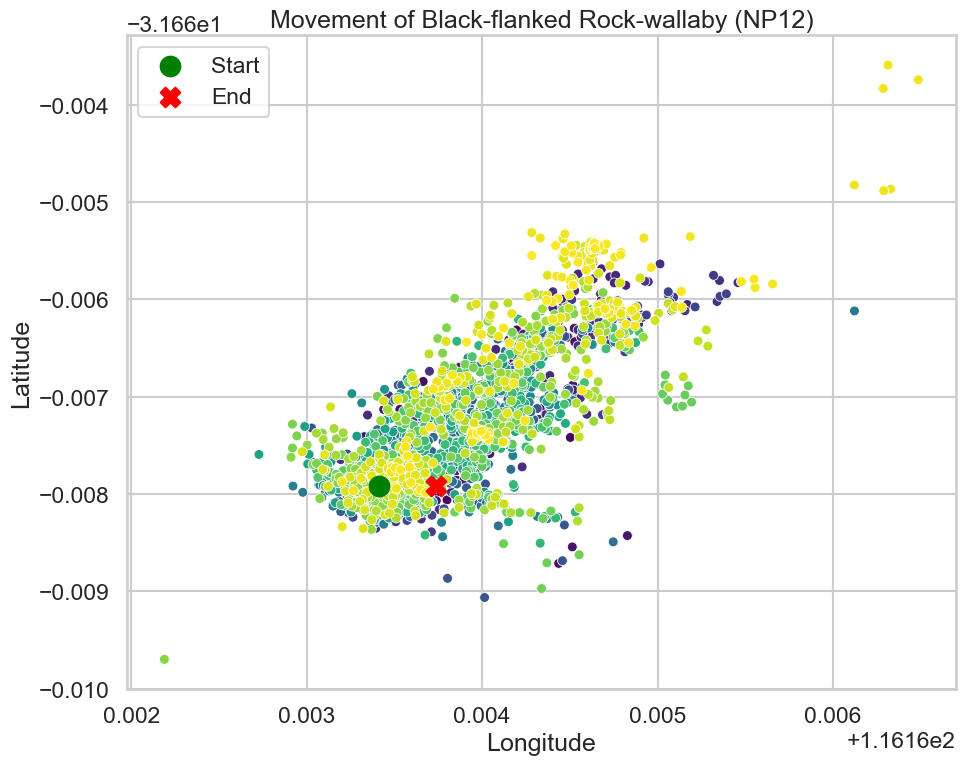

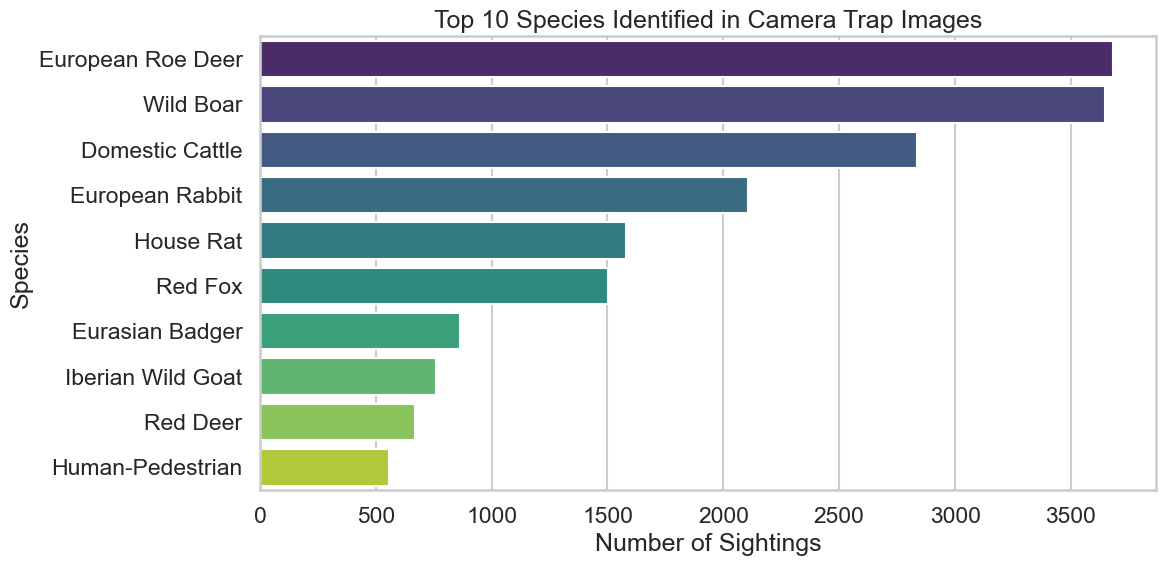

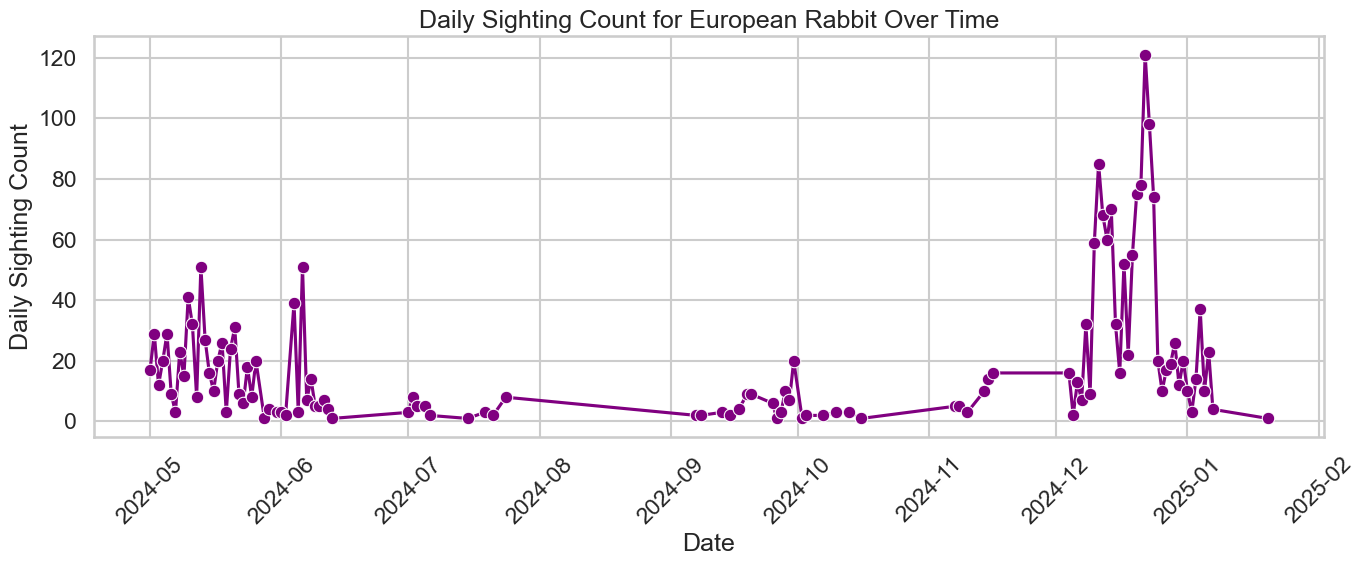

In [97]:
# Cell 5: Visualize GPS movement & species sighting distributions with correct columns

sns.set_context("talk")

# Animal movement scatter plot for GPS individual-local-identifier 'NP12'
animalidtoplot = "NP12"
singleanimal = gpsdf[gpsdf["individual-local-identifier"] == animalidtoplot].copy()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=singleanimal, x="location-long", y="location-lat", hue="timestamp", palette="viridis", s=50, legend=False)
plt.scatter(singleanimal.iloc[0]["location-long"], singleanimal.iloc[0]["location-lat"], color="green", s=200, label="Start", marker="o")
plt.scatter(singleanimal.iloc[-1]["location-long"], singleanimal.iloc[-1]["location-lat"], color="red", s=200, label="End", marker="X")
plt.title(f"Movement of Black-flanked Rock-wallaby ({animalidtoplot})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "np12movementscatter.png"))
plt.show()

# Top 10 species bar chart (correct 'common_name' column)
topspecies = imagesdf_cleaned["common_name"].value_counts().head(10).index.tolist()
topspeciesdf = imagesdf_cleaned[imagesdf_cleaned["common_name"].isin(topspecies)]

plt.figure(figsize=(12, 6))
sns.countplot(data=topspeciesdf, y="common_name", order=topspecies, palette="viridis")
plt.title("Top 10 Species Identified in Camera Trap Images")
plt.xlabel("Number of Sightings")
plt.ylabel("Species")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "topspeciesbar.png"))
plt.show()

# Daily sightings line plot for a chosen species (correct 'common_name' column)
speciestoplot = "European Rabbit"
species_sighting = sighting_counts[sighting_counts["common_name"] == speciestoplot].copy()
species_sighting["date"] = pd.to_datetime(species_sighting["date"])

plt.figure(figsize=(14, 6))
sns.lineplot(data=species_sighting, x="date", y="dailysightingcount", marker="o", color="purple")
plt.title(f"Daily Sighting Count for {speciestoplot} Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Sighting Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "dailysightingsline.png"))
plt.show()


In [98]:
import geopy.distance

# Convert timestamps and extract date
gpsdf['timestamp'] = pd.to_datetime(gpsdf['timestamp'])
gpsdf['date'] = gpsdf['timestamp'].dt.date

# Sort GPS data
gpsdf_sorted = gpsdf.sort_values(['individual-local-identifier', 'timestamp'])

# Calculate previous lat/long/time for distance computation
gpsdf_sorted['lat_prev'] = gpsdf_sorted.groupby('individual-local-identifier')['location-lat'].shift(1)
gpsdf_sorted['long_prev'] = gpsdf_sorted.groupby('individual-local-identifier')['location-long'].shift(1)
gpsdf_sorted['time_prev'] = gpsdf_sorted.groupby('individual-local-identifier')['timestamp'].shift(1)

# Function to compute distance from previous point
def compute_distance(row):
    if pd.isna(row['lat_prev']) or pd.isna(row['long_prev']):
        return 0.0
    return geopy.distance.geodesic(
        (row['location-lat'], row['location-long']),
        (row['lat_prev'], row['long_prev'])
    ).km

gpsdf_sorted['segment_distance_km'] = gpsdf_sorted.apply(compute_distance, axis=1)

# Aggregate daily total distance per individual
daily_gps = (
    gpsdf_sorted
    .groupby(['individual-local-identifier', 'date'])
    .agg({'segment_distance_km': 'sum'})
    .reset_index()
    .rename(columns={'segment_distance_km': 'daily_distance_km'})
)

# Calculate average speed per day (distance/time, assuming 24h)
daily_gps['avg_speed_kph'] = daily_gps['daily_distance_km'] / 24.0

# Now merge GPS daily features into imagesdf_cleaned
imagesdf_cleaned['date'] = pd.to_datetime(imagesdf_cleaned['timestamp']).dt.date

images_with_gps = pd.merge(
    imagesdf_cleaned,
    daily_gps,
    how='left',
    left_on=['deployment_id', 'date'],
    right_on=['individual-local-identifier', 'date']
).fillna({'daily_distance_km': 0, 'avg_speed_kph': 0})

# Build daily presence target, merge GPS features
dailylabels = (
    images_with_gps
    .assign(istarget=(images_with_gps[labelcol] == targetspecies).astype(int))
    .groupby([sitecol, 'date'], as_index=False)['istarget']
    .max()
    .rename(columns={'istarget': 'y'})
    .sort_values(['date', sitecol])
    .reset_index(drop=True)
)

# Add temporal features
dailylabels['dow'] = pd.to_datetime(dailylabels['date']).dt.dayofweek
dailylabels['month'] = pd.to_datetime(dailylabels['date']).dt.month
dailylabels['dayofyear'] = pd.to_datetime(dailylabels['date']).dt.dayofyear

# Add GPS features from merged data
# Use mean GPS features per sitecol and date from images_with_gps
gps_aggregates = (
    images_with_gps
    .groupby([sitecol, 'date'], as_index=False)
    .agg({'daily_distance_km': 'mean', 'avg_speed_kph': 'mean'})
)

# Merge GPS aggregates onto dailylabels
dailylabels = pd.merge(
    dailylabels,
    gps_aggregates,
    on=[sitecol, 'date'],
    how='left'
).fillna({'daily_distance_km': 0, 'avg_speed_kph': 0})

# Lag and rolling features on target
dailylabels['ylag'] = dailylabels.groupby(sitecol)['y'].shift(1)
dailylabels['yroll3mean'] = (
    dailylabels.groupby(sitecol)['y']
    .shift(1)
    .rolling(3)
    .mean()
    .reset_index(level=0, drop=True)
)

# Final features and target for ML
X = dailylabels[[sitecol, 'dow', 'month', 'dayofyear', 'ylag', 'yroll3mean', 'daily_distance_km', 'avg_speed_kph']]
y = dailylabels['y'].astype(int)

print(f"Enhanced ML Data shape: {X.shape}")
print(X.head())


Enhanced ML Data shape: (1437, 8)
                    deployment_id  dow  month  dayofyear  ylag  yroll3mean  \
0  Cerro de la Campana 02/05/2025    6      1          2   NaN         NaN   
1  Cerro de la Campana 02/05/2025    0      1          3   0.0         NaN   
2  Cerro de la Campana 02/05/2025    1      1          4   0.0         NaN   
3  Cerro de la Campana 02/05/2025    2      1          5   0.0         0.0   
4  Cerro de la Campana 02/05/2025    3      1          6   0.0         0.0   

   daily_distance_km  avg_speed_kph  
0                0.0            0.0  
1                0.0            0.0  
2                0.0            0.0  
3                0.0            0.0  
4                0.0            0.0  


In [99]:
pip install xgboost



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [100]:
pip install lightgbm



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Training


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Define your categorical and numerical feature columns
catcols = [sitecol]  # assumes sitecol is defined above in your context e.g., 'deployment_id'
numcols = ['dow', 'month', 'dayofyear', 'ylag', 'yroll3mean', 'daily_distance_km', 'avg_speed_kph']

# Fill missing target values if any (usually handled prior)
y = y

# OneHotEncoder setup - note: use sparse_output=False for scikit-learn >=1.2, else sparse=False for older
from sklearn import __version__ as sklearn_version
from distutils.version import LooseVersion

if LooseVersion(sklearn_version) >= LooseVersion("1.2"):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Preprocessing pipeline for numeric - imputation and scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Full preprocessing transformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', ohe, catcols),
    ('num', numeric_transformer, numcols)
])

# Define classifiers with class_weight where applicable
base_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=4000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}

# Hyperparameter distributions for tuning
param_distributions = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [5, 10, 20, None],
        'model__min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2]
    },
    'SVM': {
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto']
    }
}

tscv = TimeSeriesSplit(n_splits=5)

def tune_and_evaluate_model(name, model, param_dist=None):
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

  
print("\nFinal aggregated results:\n", results_df)



Model: Logistic Regression
Mean Precision: 0.381
Mean Recall: 0.382
Mean F1 Score: 0.365
Mean ROC AUC: 0.848
Mean Matthews Corr: 0.343

Model: Random Forest
Mean Precision: 0.561
Mean Recall: 0.419
Mean F1 Score: 0.477
Mean ROC AUC: 0.891
Mean Matthews Corr: 0.467

Model: Gradient Boosting
Mean Precision: 0.382
Mean Recall: 0.221
Mean F1 Score: 0.252
Mean ROC AUC: 0.710
Mean Matthews Corr: 0.267

Model: SVM
Mean Precision: 0.532
Mean Recall: 0.484
Mean F1 Score: 0.506
Mean ROC AUC: 0.800
Mean Matthews Corr: 0.491

Model: KNN
Mean Precision: 0.626
Mean Recall: 0.507
Mean F1 Score: 0.545
Mean ROC AUC: 0.839
Mean Matthews Corr: 0.533

Final aggregated results:
                  Model  Precision    Recall  F1 Score   ROC AUC  Matthews Corr
1        Random Forest   0.560645  0.419354  0.476758  0.891121       0.466717
0  Logistic Regression   0.380862  0.381686  0.364695  0.847647       0.342714
4                  KNN   0.626424  0.507123  0.544855  0.838791       0.533037
3               

Results and discussion

Best model: Random Forest


<Figure size 600x600 with 0 Axes>

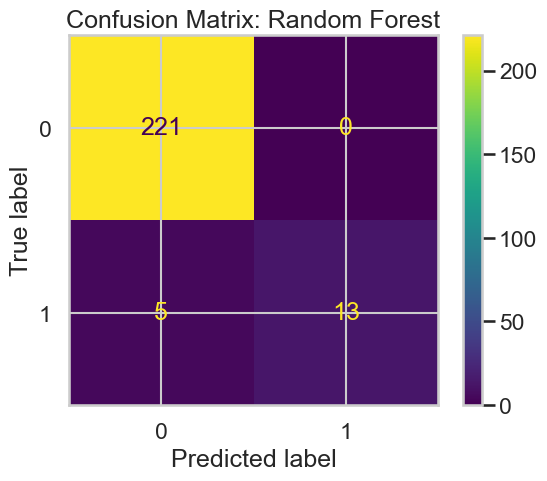

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       221
           1       1.00      0.72      0.84        18

    accuracy                           0.98       239
   macro avg       0.99      0.86      0.91       239
weighted avg       0.98      0.98      0.98       239



<Figure size 800x600 with 0 Axes>

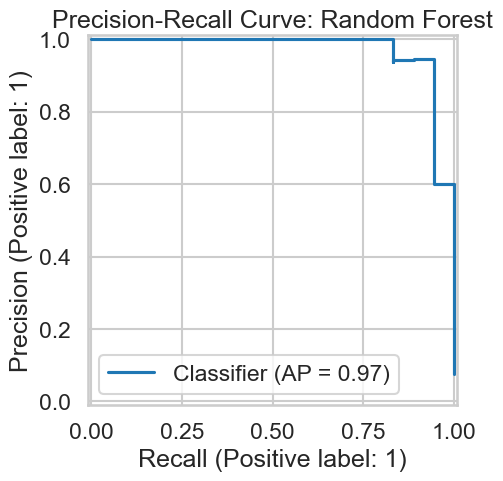

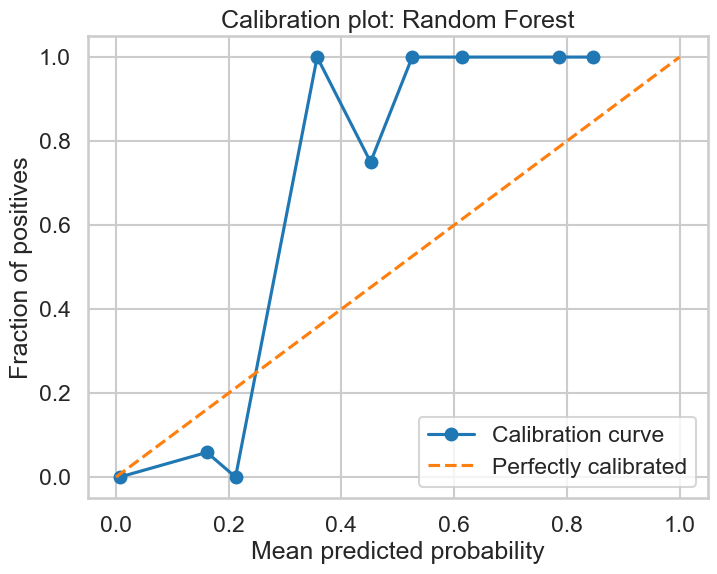

KeyError: 'preproc'

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, classification_report
from sklearn.calibration import calibration_curve
import numpy as np
import seaborn as sns

if best_model_info:

    print(f"Best model: {best_model_info['name']}")

    # Confusion Matrix
    plt.figure(figsize=(6, 6))
    cm_display = ConfusionMatrixDisplay.from_predictions(best_model_info['y_test'], best_model_info['y_pred'])
    plt.title(f"Confusion Matrix: {best_model_info['name']}")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(best_model_info['y_test'], best_model_info['y_pred']))

    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    pr_display = PrecisionRecallDisplay.from_predictions(best_model_info['y_test'], best_model_info['y_scores'])
    plt.title(f"Precision-Recall Curve: {best_model_info['name']}")
    plt.show()

    # Calibration Plot
    prob_true, prob_pred = calibration_curve(best_model_info['y_test'], best_model_info['y_scores'], n_bins=10)
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.title(f"Calibration plot: {best_model_info['name']}")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend()
    plt.show()

    # Feature Importance if supported
    model = best_model_info['pipeline'].named_steps['model']
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        # Extract feature names: OneHotEncoder features + numerical cols
        onehot_features = best_model_info['pipeline'].named_steps['preproc'].transformers_[0][1].get_feature_names_out(catcols).tolist()
        feature_names = onehot_features + numcols
        feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=[imp[1] for imp in feature_importance], y=[imp[0] for imp in feature_importance])
        plt.title(f"Feature Importance ({best_model_info['name']})")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

else:
    print("No best model info to display evaluation.")
